# Capstone: Airbnb Price Listing Prediction
## Part 4 Model Tuning

_Authors: Evonne Tham_

In the previous notebook, the XGBoost produced a high $R^2$ score of 0.9665 and 7.849000e-01 for the train and validation sets respectively, and an $RMSE$ of 8995.01. Despite this, the model needs to be tuned by narrowing the features from 324 features to a more manageable number so that the model is more generalisable and for inferences about the data to be easily made. 

This will be done by utilising the features importance, a built-in function in XGBoost, after they have been modelled. This model will be used as the production model in the next notebook.

## Contents of this notebook
- [1. Import Necessary Libraries and Load Data](#1.-Import-Necessary-Libraries-and-Load-Data)
- [2. GridSearch for Hyperparameter Tuning](#2.-GridSearch-for-Hyperparameter-Tuning)
    - [2.1. Defining Function for modelling](#2.1-Defining-Function-for-modelling)
    - [2.2. Fitting Models](#2.2.-Fitting-Models)
- [3. Model Evaluation](#3.-Model-Evaluation)
- [4. Re-training the Best Model (XGBoost)](#4.-Re-training-the-Best-Model-(XGBoost))
- [5. Feature Selection](#5.-Feature-Selection)
    - [5.1. Feature Importances](#5.1.-Feature-Importances)
    - [5.2. Dropping Features](#5.2.-Dropping-Features)
- [6. Re-training the XGBoost with Selected Features](#6.-Re-training-the-XGBoost-with-Selected-Features)
- [7. Learning Curve](#7.-Learning-Curve)


## 1. Import Necessary Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, accuracy_score
# from xgboost import plot_importance


#Hide warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load in Data 
train = pd.read_csv('../datasets/train.csv')

#Set id as index 
train.set_index('id', inplace=True)

print(f"Total Number of Listing: {train.shape[0]} | Total Number of Features: {train.shape[1]}")

Total Number of Listing: 10789 | Total Number of Features: 134


---
## 2. Model Prep

In [3]:
# Create X and y variables
features = [col for col in train._get_numeric_data().columns 
            if col != 'price' 
            and col != 'log_price' 
            and col != 'id' 
            and col != 'host_id']

X = train[features]
y = train['price']

# Validation Set 
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

---
## 3. GridSearch for Hyperparameter Tuning

### 3.1 Defining Function for modelling

Some of the important hyperparameters to tune an SVR are:
- C: Regularization parameter
- gamma: defines how much influence a single training example has
- Kernel: helps find a hyperplane in the higher dimensional space without increasing the computational cost.

Some of the important hyperparameters to tune an XGBoost are:

- gamma: Specifies the minimum loss reduction required to make a split.
- learning_rate: Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
- max_depth: Determines how deeply each tree is allowed to grow during any boosting round.
- n_estimators:  Number of trees one wants to build.
- subsample: Ratio of the training instances which help in prevent overfitting.

In [4]:
def grid_modeller_val_scorer(classifier): 
    
    '''
    takes arguments "lr", "enet", "svr", "xgb"
    '''
    
    start = time.time()
    
    # Model instantiation
    clf_lr = LinearRegression()
    clf_enet = ElasticNetCV()
    clf_svr = SVR()
    clf_xgb = XGBRegressor()
    
    # Building the model pipelines incl. preprocessing where needed 
    # Setting up the parameter grids
    if classifier == "lr":
        pipe_lr = Pipeline([('rs', RobustScaler()),
                             ('clf_lr', clf_lr)])
        
        param_grid_lr = [{'clf_lr__fit_intercept': [True, False],
                          'clf_lr__normalize': [True, False]}]
        

        gs = GridSearchCV(pipe_lr, 
                          param_grid_lr, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1, 
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)
        
        
    elif classifier == "enet":
        pipe_enet = Pipeline([('rs', RobustScaler()), 
                             ('clf_enet', clf_enet)])
        
        param_grid_enet = [{'clf_enet__l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
                            'clf_enet__n_alphas': [1,10,100,1000,10000]}]
    
        gs = GridSearchCV(pipe_enet, 
                          param_grid_enet, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1, 
                          scoring = "r2") 
    
        gs.fit(X_train, y_train)
        
        
    elif classifier == "svr":
        pipe_svr = Pipeline([('rs', RobustScaler()),
                             ("clf_svr", clf_svr)])

        param_grid_svr = [{"clf_svr__C":[1,10], 
                          "clf_svr__gamma":[0.001, 0.01, 0.1, 1], 
                          "clf_svr__kernel":('linear', 'rbf')}]  
        
        gs = GridSearchCV(pipe_svr, 
                          param_grid_svr, 
                          cv=5, 
                          n_jobs=1, 
                          verbose=1,
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)   
        
    
    elif classifier == "xgb":
        pipe_xgb = Pipeline([('rs', RobustScaler()),
                            ("clf_xgb",clf_xgb)])
        
        param_grid_xgb  = [{
            'clf_xgb__gamma':[0, 0.3], 
            'clf_xgb__learning_rate': [0.05, 0.3], 
            'clf_xgb__max_depth':[2,3,5], 
            'clf_xgb__n_estimators': [1000], 
            'clf_xgb__subsample': [0.05, 0.3, 0.5]
        }]
                        
        gs = GridSearchCV(pipe_xgb, 
                          param_grid_xgb, 
                          cv=5, 
                          n_jobs=-1, 
                          verbose=1,
                          scoring = "r2") 
        
        gs.fit(X_train, y_train)
        
    end = time.time()
        
    #get scores
    train_score = gs.score(X_train, y_train)
    val_score = gs.score(X_val, y_val)
    y_pred = gs.predict(X_val)
    
    #get R2, MSE Score, RMSE score
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = (mean_squared_error(y_val, y_pred))**0.5
    
    
    
    metrics_list= [train_score, val_score, gs.best_score_, r2, mse, rmse]
    
    # Print out total run time 
    print(f"Time taken to run: {round((end - start)/60,1)} minutes")
    print('==================================================================================')
    print('')

    # print out accuracy, estimator and parameters from GridSearchCV
    print(f'Best train accuracy score = {train_score}')
    print(f'Best validation accuracy score = {val_score}')
    print(f'Best grid search score = {gs.best_score_}')
    print(f'R2 score = {r2}')
    print(f'Mean Square Error = {mse}')
    print(f"Root mean squared error = {rmse}")
    print('==================================================================================')
    print('')
    
    print(f'Best estimator = {gs.best_estimator_}')
    print(f'Best parameters = {gs.best_params_}')
    print('==================================================================================')
    print('')
    
    print(f"metrics list for {classifier}:", metrics_list)
    
    return

### 3.2. Fitting Models

#### i. Linear Regression

In [5]:
grid_modeller_val_scorer("lr")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time taken to run: 0.0 minutes

Best train accuracy score = 0.26351972105776644
Best validation accuracy score = 0.2532626597046691
Best grid search score = 0.24125188388851365
R2 score = 0.2532626597046691
Mean Square Error = 344995616.9268208
Root mean squared error = 18574.057632268206

Best estimator = Pipeline(memory=None,
         steps=[('rs',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Best parameters = {'clf_lr__fit_intercept': True, 'clf_lr__normalize': False}

metrics list for lr: [0.26351972105776644, 0.2532626597046691, 0.24125188388851365, 0.2532626597046691, 344995616.9268208, 18574.057632268206]


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.6s finished


#### ii. ElasticNetCV

In [6]:
grid_modeller_val_scorer("enet")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed: 13.6min finished


Time taken to run: 13.6 minutes

Best train accuracy score = 0.26161742694115997
Best validation accuracy score = 0.2545576625293372
Best grid search score = 0.24488045103092648
R2 score = 0.2545576625293372
Mean Square Error = 344397320.47864574
Root mean squared error = 18557.944942224764

Best estimator = Pipeline(memory=None,
         steps=[('rs',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_enet',
                 ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
                              fit_intercept=True, l1_ratio=1, max_iter=1000,
                              n_alphas=10, n_jobs=None, normalize=False,
                              positive=False, precompute='auto',
                              random_state=None, selection='cyclic', tol=0.0001,
                              verbose=0))],
         verbose=False)
Best parameters = {'clf_enet__l1

#### iii. Support Vector Regressor

In [7]:
grid_modeller_val_scorer("svr")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 11.2min finished


Time taken to run: 11.4 minutes

Best train accuracy score = 0.05244981617119615
Best validation accuracy score = 0.04919455905392278
Best grid search score = 0.047670829580747046
R2 score = 0.04919455905392278
Mean Square Error = 439275889.8956868
Root mean squared error = 20958.909558841242

Best estimator = Pipeline(memory=None,
         steps=[('rs',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_svr',
                 SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma=0.001, kernel='linear', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
Best parameters = {'clf_svr__C': 10, 'clf_svr__gamma': 0.001, 'clf_svr__kernel': 'linear'}

metrics list for svr: [0.05244981617119615, 0.04919455905392278, 0.047670829580747046, 0.04919455905392278, 439275889.8956868, 20958.909558841242]


#### iv. Extreme Gradient Boosting Trees Regressor ("XGB") 

In [8]:
grid_modeller_val_scorer("xgb")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 27.4min finished


Time taken to run: 27.8 minutes

Best train accuracy score = 0.9612198204358755
Best validation accuracy score = 0.7877258371238189
Best grid search score = 0.7505779527761703
R2 score = 0.7877258371238189
Mean Square Error = 98071506.30786587
Root mean squared error = 9903.105891984891

Best estimator = Pipeline(memory=None,
         steps=[('rs',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('clf_xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=nan, monotone_constrain

---
## 4. Model Evaluation
The evaluation metrics used will be mean squared error (for loss) and r squared (for accuracy).

In [15]:
metrics_list= ["train_score", "val_score", "gs.best_score_", "r2", "mse", "rmse"]

lr = [0.26351972105776644, 0.2532626597046691, 
      0.24125188388851365, 0.2532626597046691, 
      344995616.9268208, 18574.057632268206]
    
enet = [0.26161742694115997, 0.2545576625293372, 
        0.24488045103092648, 0.2545576625293372, 
        344397320.47864574, 18557.944942224764]

svr = [0.05244981617119615, 0.04919455905392278, 
       0.047670829580747046, 0.04919455905392278, 
       439275889.8956868, 20958.909558841242]

xgb = [0.9612198204358755, 0.7877258371238189, 
       0.7505779527761703, 0.7877258371238189, 
       98071506.30786587, 9903.105891984891]


eval_data = [lr, enet, svr, xgb]

column_names = metrics_list

index = ["Linear Regression", "ElasticNetCV", "Support Vector Regressor", "XGBoost"]

eval_df = pd.DataFrame(eval_data, columns=column_names, index=index)
    
eval_df = eval_df.round(decimals = 4)
eval_df

,train_score,val_score,gs.best_score_,r2,mse,rmse
Linear Regression,0.2635,0.2533,0.2413,0.2533,3.449956e+08,18574.0576
ElasticNetCV,0.2616,0.2546,0.2449,0.2546,3.443973e+08,18557.9449
Support Vector Regressor,0.0524,0.0492,0.0477,0.0492,4.392759e+08,20958.9096
XGBoost,0.9612,0.7877,0.7506,0.7877,9.807151e+07,9903.1059


Based on this table and our particular output reproduced above, we can see that Support Vector Machine Regressor performed the worst as the train set has a $R^2$ of 0.0524 and 0.0492 on the validation set. This handily beats the baseline model score of -0.00029.

Linear Regression and ElasticNet performed poorly, eventhough there's not much difference between the $R^2$ score of 0.2635 and 0.2616 on train set and $R^2$ score of 0.2533 and 0.2546 on validation set respectively. 

Hence the clear winner is eXtreme Gradient Boosting. It has the highest $R^2$ of 0.78 on the entire validation set means that our model is able to account for almost 80% of the variance in the target variable. With a $RMSE$ score of 9903.10, what this means is that our model's prediction is on average off by 9903¥ in terms of predicting the property's price. This is pretty good for a preliminary model using regression techniques.

***The best parameters are:*** 
- gamma: 0, 
- learning_rate: 0.05, 
- max_depth: 5, 
- n_estimators: 1000, 
- subsample: 0.5

---
## 5. Re-training the Best Model (XGBoost)

Now that we've selected the model with the best performance on the validation set, we're going to tetrain the model on the combined train + validation sets using our best hyperparameter combination.

In [19]:
# Create X and y variables
features = [col for col in train._get_numeric_data().columns 
            if col != 'price' 
            and col != 'log_price' 
            and col != 'id' 
            and col != 'host_id']

X = train[features]
y = train['price']

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

# Scale 
rs = RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_val_rs = rs.transform(X_val)

# Instantiate Best Model
xgb = XGBRegressor(gamma = 0,
                   learning_rate = 0.05, 
                   max_depth = 5, 
                   n_estimators = 1000, 
                   subsample = 0.5)

# Fit Model
xgb.fit(X_train_rs, y_train)

# Predict
y_pred_train = xgb.predict(X_train_rs)
y_pred_val = xgb.predict(X_val_rs)

# Model Evaluation
# Model Evaluation
r2 = r2_score(y_val, y_pred_val)
print(f"R2 Score on Validation Set: {round(r2, 4)}")

mse = mean_squared_error(y_val, y_pred_val)
print(f"MSE Score on Validation Set: {round(mse, 4)}")

rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE Score on Validation Set: {round(rmse, 4)}")

R2 Score on Validation Set: 0.7877
MSE Score on Validation Set: 98071506.3079
RMSE Score on Validation Set: 9903.1059


Once again, it has a $R^2$ of 0.78 on the validation set and a $RMSE$ score of 9903.10. hence we can proceed futher with the analysis

--- 
## 6. Feature Selection

### 6.1. Feature Importances

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

Credit: [Feature Importance and Feature Selection With XGBoost in Python](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)

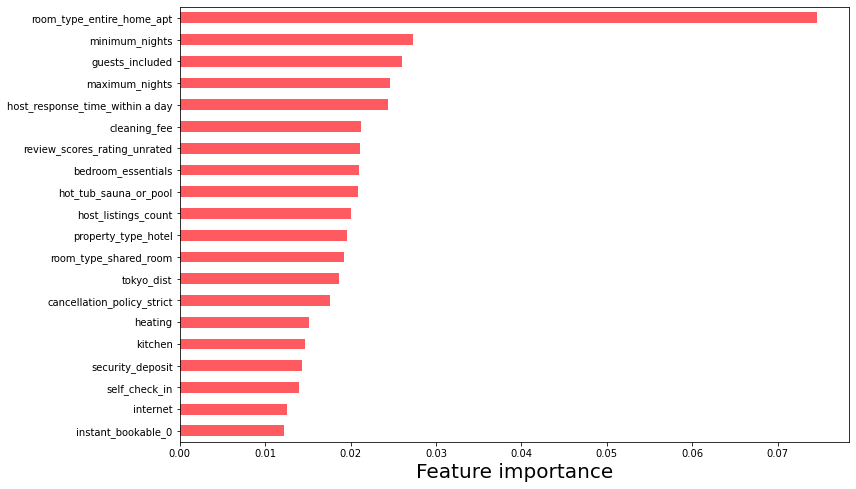

In [23]:
# Visualizing top features in our production model. 
key_features = pd.Series(xgb.feature_importances_, index = X.columns)
key_features.nlargest(20).sort_values().plot(kind='barh', color = '#FF5A5F', figsize = (12,8))
plt.xlabel("Feature importance", fontsize=20);

<div class="alert alert-block alert-warning">
About a good number of features have a feature importance of 0 in this XGBoost regression model, and could potentially be removed.

The top 10 most important features are:
1. If the rental is the entire flat or not room_type_Entire home/apt (room_type_entire_home_apt)
2. The minimum night stays (minimum_nights)
3. How many guests is included (guests_included)
4. The maximum nights stay (maximum_nights)
5. How fast the host response (host_response_time_within_a_day)
6. How much is the cleaning fee (cleaning_fee)
7. unrated reviews
8. Availability of bedroom amenities (bedroom_essentials)
9. Hot tub/sauna/pool
10. Number of listing a host has. 

The most important features the rental being the entire flat. Which makes sense. Asking price is higher if the offer is for the entire flat/house. This could also suggest that offering the flat/house as a whole, rather than each bedroom individually, may be better overall, given the large difference in importance compared to the second most important feature.

It is perhaps more surprising that location features did not appear in the top ten. Although we can observe that belonging to a certain neighbourhood increases price more than others and Score (accessibility measure) also shows some importance, they are of relative low importance compared to the top 3 features. Review Scores Location is higher on the importance list (number 11). This is, it is likely renters put more weight in other's opinion about location instead of judging the location based on neighbourhood and venues around the property. This could also be because Edinburgh is a small and walkable city with good transportation services. Thus, location is not a major problem to reaching main touristic attractions and amenities.

The eight most important feature is related to how many other listings the host manages on Airbnb, rather than the listing itself. This result showed on this analysis of Airbnb listings in London, only this feature was the third most important. What the researcher (and former data scientists at an Airbnb management company) explains is that this does not mean that a host that manages more properties will result in a listing gaining higher prices, and could be due to experienced hosts setting higher prices. Also, it could be that big Airbnb management companies that have lots of listings tend to manage more expensive properties than single listing hosts.
</div>

### 6.2. Dropping Features

In [ ]:
top_features = 

##### Save Final Dataframe

In [ ]:
# top_features.to_csv("../datasets/top_features.csv")

## 7. Re-training the XGBoost with Selected Features

In [ ]:
# Create X and y variables
features = [col for col in train._get_numeric_data().columns if col != 'price']

X = top_features[features]
y = top_features['price']

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.25,
                                                  random_state = 42) 

# Scale 
rs = RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_val_rs = rs.transform(X_val)

# Instantiate Best Model
xgb = XGBRegressor(gamma = 0,
                   learning_rate = 0.05, 
                   max_depth = 5, 
                   n_estimators = 1000, 
                   subsample = 0.5)

# Fit Model
xgb.fit(X_train_rs, y_train)

# Predict
y_pred_train = xgb.predict(X_train_rs)
y_pred_val = xgb.predict(X_val_rs)

# Model Evaluation
RMSE = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_val, y_pred_val)
print(f"r2: {round(r2, 4)}")

## 8. Learning Curve

In [13]:
# from sklearn.model_selection import learning_curve
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')
# %matplotlib inline

# def plot_learning_curve(estimator, clf, X, y, ylim=None, cv=None, train_sizes=None):
#     plt.figure()
#     plt.title(f'Learning Curves ({clf})')
#     plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     plt.grid(True)
#     return

In [14]:
# train_sizes = np.linspace(.1, 1.0, 5)
# ylim = (0.9, 1.01)
# cv = 5

# plot_learning_curve(pipe_lr, "Linear Regression", X_val, y_val, 
#                     ylim=ylim, cv=cv, train_sizes=train_sizes)
# plot_learning_curve(pipe_enet, "ElasticNetCV", X_val, y_val, 
#                     ylim=ylim, cv=cv, train_sizes=train_sizes)
# plot_learning_curve(pipe_svr, "SVR", X_val, y_val, 
#                     ylim=ylim, cv=cv, train_sizes=train_sizes)
# plot_learning_curve(pipe_xgb, "XGBoost", X_val, y_val,
#                     ylim=ylim, cv=cv, train_sizes=train_sizes)

# plt.show()

----> Proceed to the next notebook for [Production Model](./05_Production_Model.ipynb)